# Looking at data

In [53]:
import os
import io
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import SimpleITK as sitk

In [54]:
data_dir = Path('../data/extracted')

In [55]:
# lung CT window info
window_w = 1500
window_l = -600

In [56]:
def appply_window(data, l=window_l, w=window_w):
    min_value = l - w / 2
    max_value = l + w / 2
    return np.clip(data, min_value, max_value)

## 2019nCoVR dataset

In [5]:
ds_dir = data_dir/'2019nCoVR'

In [6]:
all_files = list(ds_dir.glob('*CP/**/*.png'))
len(all_files)

276036

In [7]:
random_set = random.sample(all_files, 1000)

In [8]:
random_img = random.choice(all_files)

In [9]:
# load the image
image = Image.open(random_img)

# convert image to numpy array
data = np.asarray(image)

data.min(), data.mean(), data.max()

(38, 161.1145362854004, 255)

#### Looking at one random image

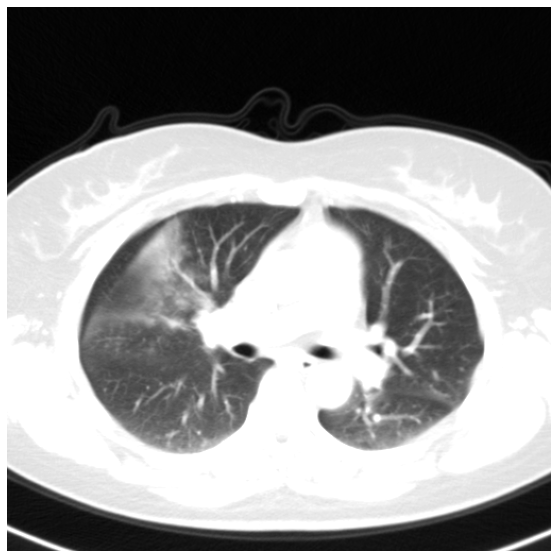

In [10]:
plt.figure(figsize = (10, 10))
plt.imshow(data, cmap='gray')
plt.axis('off');

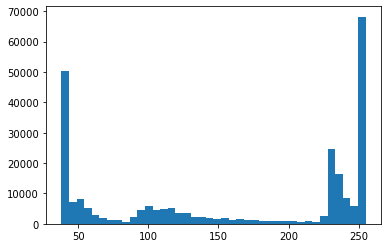

In [11]:
plt.hist(data.flatten(), bins=40);

#### Looking at random subset

In [12]:
# convert image to numpy array
arrays = [np.asarray(Image.open(f)) for f in random_set]

In [13]:
from collections import Counter

shapes = [a.shape for a in arrays]
Counter(shapes)

Counter({(512, 512): 996, (1024, 1024): 4})

#### Discarding images with other shapes

In [14]:
data = np.stack([a for a in arrays if a.shape == (512, 512)])
data.shape

(996, 512, 512)

In [15]:
data.min(), data.mean(), data.max()

(0, 124.7279480700512, 255)

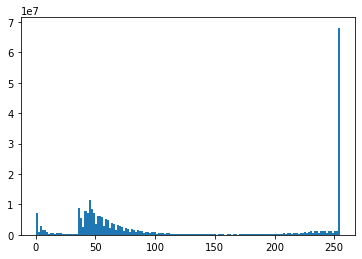

In [16]:
plt.hist(data.flatten(), bins=150);

#### Looking at items with min_val close to 0

In [17]:
tmp_arrays = [a for a in arrays if a.shape == (512, 512) and a.min() < 10]
len(tmp_arrays)

194

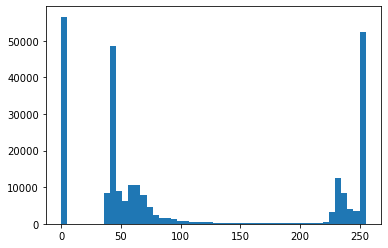

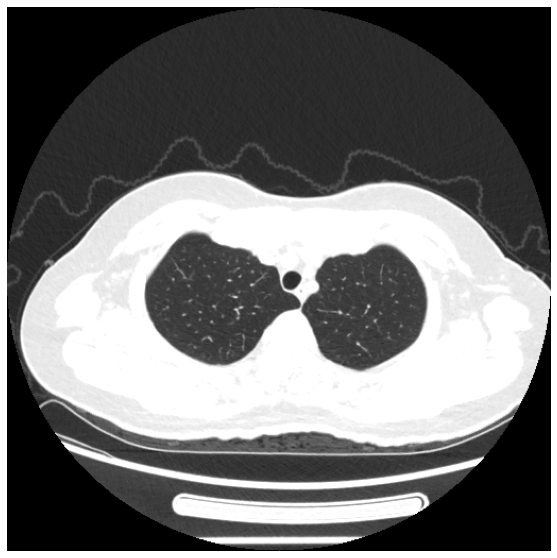

In [18]:
tmp_data = tmp_arrays[13]
plt.hist(tmp_data.flatten(), bins=50);
plt.figure(figsize = (10, 10))
plt.imshow(tmp_data, cmap='gray')
plt.axis('off');

#### We can see that window has been applied to the original DICOM images, but values squeezed to 0-250 range and moved

In [40]:
rescaled_data = (data - 255.0) * 5

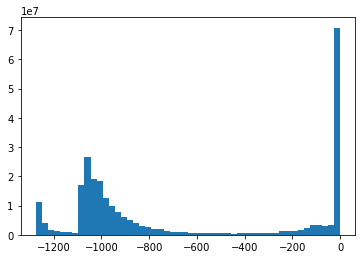

In [41]:
plt.hist(rescaled_data.flatten(), bins=50);

### This looks similar to lung windowed CT image, but not exact. Looks like the top limit is a bit lower than the default one. We can try adding this dataset later

## COVID19_1110 dataset

In [199]:
ds_dir = data_dir/'COVID19_1110'

In [200]:
all_files = list(ds_dir.rglob('*.nii'))

In [201]:
len(all_files)

1110

In [202]:
random_set = random.sample(all_files, 10)

In [203]:
random_img = random.choice(all_files)

In [204]:
# Read the .nii image containing the volume with SimpleITK:
dcm = sitk.ReadImage(str(random_img))

# and access the numpy array:
data = sitk.GetArrayFromImage(dcm)

data.min(), data.mean(), data.max()

(-2048, -839.5957806235865, 3847)

In [205]:
data.shape

(38, 512, 512)

#### Looking at one random image

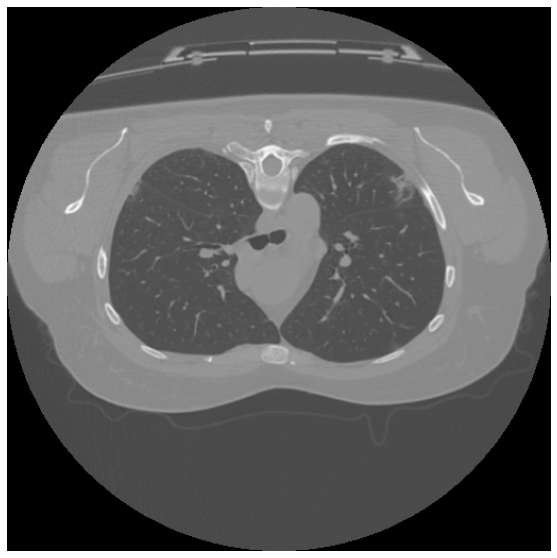

In [206]:
plt.figure(figsize = (10, 10))
plt.imshow(data[25], cmap='gray')
plt.axis('off');

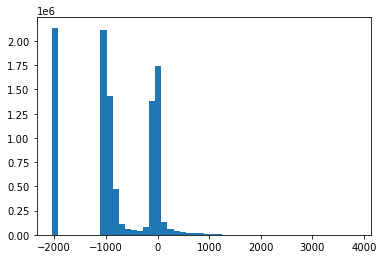

In [207]:
plt.hist(data.flatten(), bins=50);

#### We can see that this image have no CT window applied

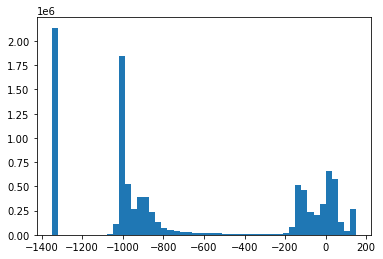

In [219]:
# windowed data
w_data = appply_window(data)
plt.hist(w_data.flatten(), bins=50);

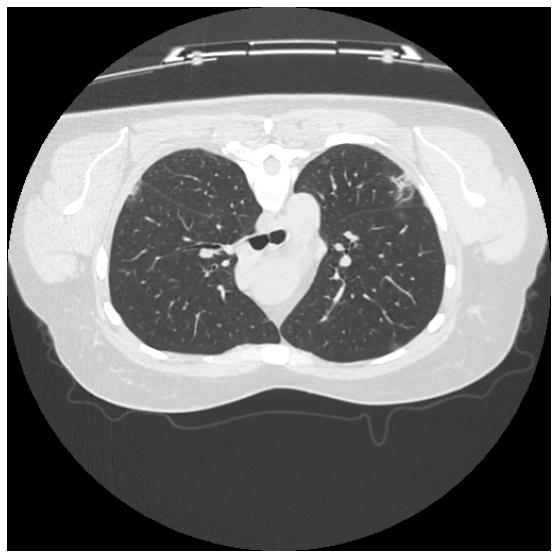

In [209]:
plt.figure(figsize = (10, 10))
plt.imshow(w_data[25], cmap='gray')
plt.axis('off');

### Normal DICOM data. We can apply the conventional lung window and save as numpy

## COVID-CTset 

In [247]:
ds_dir = data_dir/'COVID-CTset'

In [248]:
all_files = list(ds_dir.rglob('*.tif'))

In [249]:
len(all_files)

63849

In [250]:
random_set = random.sample(all_files, 1000)

In [251]:
random_img = random.choice(all_files)

In [252]:
def read_covid_ctset_img(img_path):
    with open(img_path, 'rb') as f:
        tif = Image.open(io.BytesIO(f.read()))

    return np.array(tif)

In [253]:
# load the image
data = read_covid_ctset_img(random_img)

data.min(), data.mean(), data.max()

(0, 431.6964530944824, 2556)

#### Looking at one random image

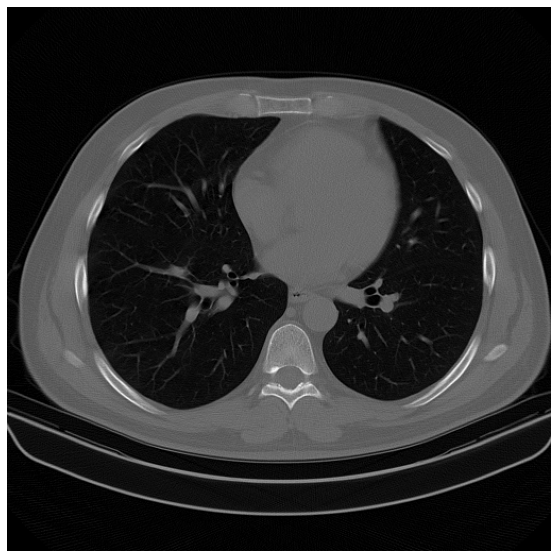

In [254]:
plt.figure(figsize = (10, 10))
plt.imshow(data, cmap='gray')
plt.axis('off');

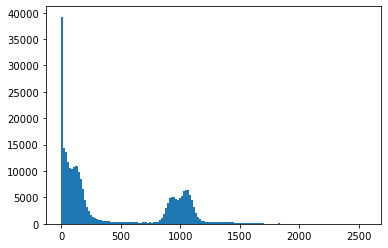

In [255]:
plt.hist(data.flatten(), bins=150);

#### Looking at random subset

In [256]:
# convert image to numpy array
arrays = [read_covid_ctset_img(f) for f in random_set]

In [260]:
data = np.stack(arrays)
data.shape

(1000, 512, 512)

In [261]:
data.min(), data.mean(), data.max()

(0, 489.66296585464477, 4095)

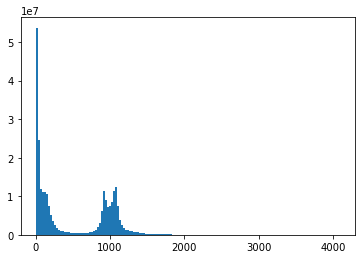

In [262]:
plt.hist(data.flatten(), bins=150);

#### This data looks weird

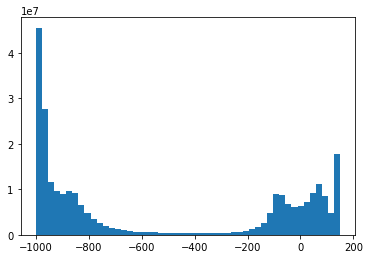

In [264]:
# windowed and moved data
w_data = appply_window(data - 1000.0)
plt.hist(w_data.flatten(), bins=50);

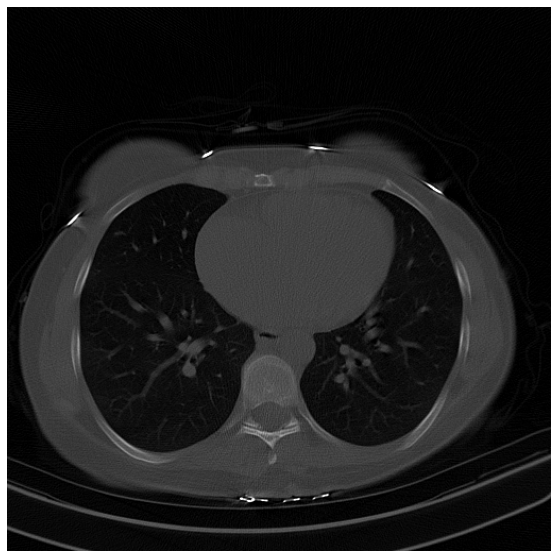

In [269]:
plt.figure(figsize = (10, 10))
plt.imshow(data[3], cmap='gray')
plt.axis('off');

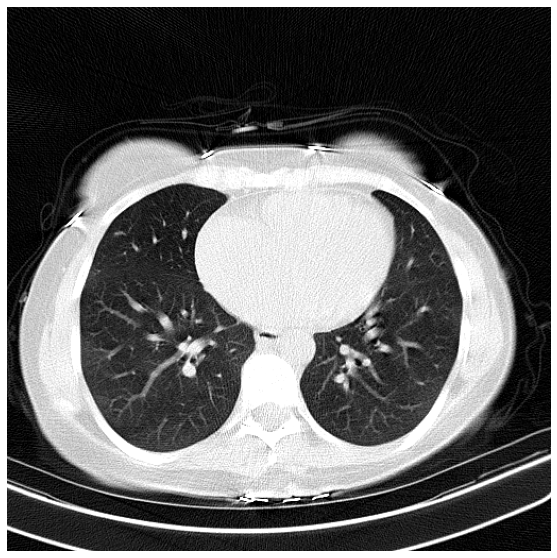

In [270]:
plt.figure(figsize = (10, 10))
plt.imshow(w_data[3], cmap='gray')
plt.axis('off');

#### Maybe this is the right rescaling but I am not sure. We can try it out later

## Kaggle: OSIC Pulmonary Fibrosis Progression

In [56]:
ds_dir = data_dir/'osic-pulmonary-fibrosis-progression'

In [74]:
all_files = list(ds_dir.rglob('ID0*'))

In [75]:
len(all_files)

181

In [76]:
random_set = random.sample(all_files, 10)

In [78]:
random_img = random.choice(all_files)
random_img

WindowsPath('../data/extracted/osic-pulmonary-fibrosis-progression/train/ID00119637202215426335765')

In [80]:
def read_dicom_folder(folder):
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(reader.GetGDCMSeriesFileNames(str(folder)))

    itk_image = reader.Execute()
    image = sitk.GetArrayFromImage(itk_image)
    
    return image

In [81]:
data = read_dicom_folder(random_img)

data.min(), data.mean(), data.max()

(-1024, -558.5514616630446, 1538)

In [82]:
data.shape

(71, 512, 512)

#### Looking at one random image

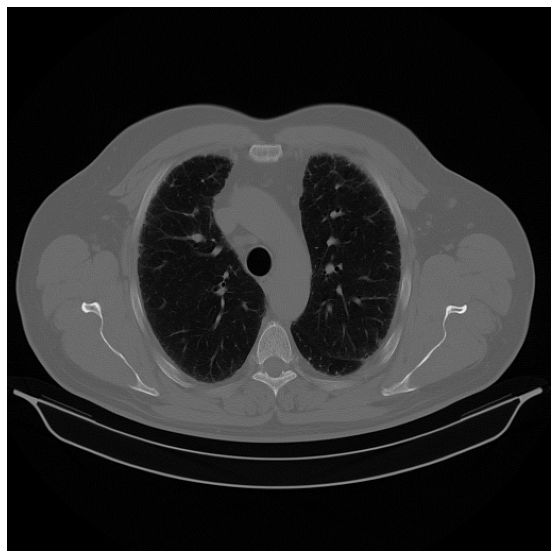

In [84]:
plt.figure(figsize = (10, 10))
plt.imshow(data[50], cmap='gray')
plt.axis('off');

#### We can see that this image have no CT window applied

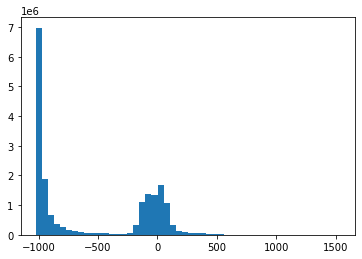

In [85]:
plt.hist(data.flatten(), bins=50);

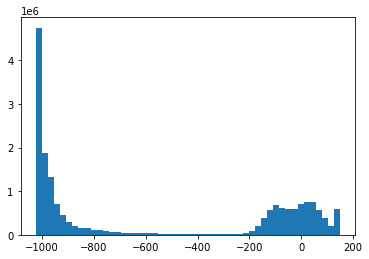

In [86]:
# windowed data
w_data = appply_window(data)
plt.hist(w_data.flatten(), bins=50);

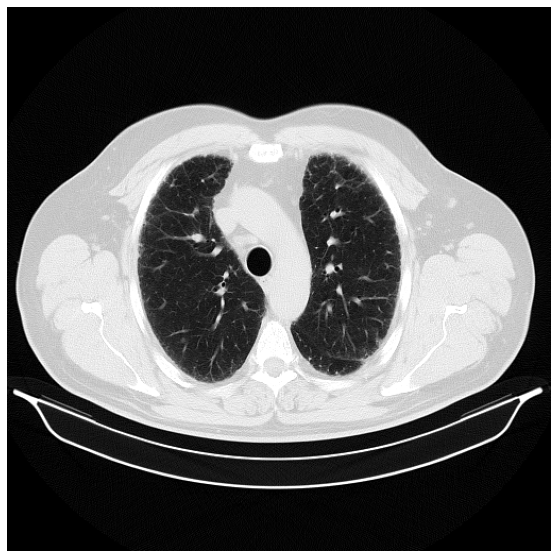

In [87]:
plt.figure(figsize = (10, 10))
plt.imshow(w_data[50], cmap='gray')
plt.axis('off');